# English Premier League - VAR Analysis
## Part 2 - Analysis of VAR Incidents
___

### Background
- Video Assistant Referee (VAR) was introduced in the English Premier League in 2019/2020
- This dataset includes the goals and incidents (of 2019/2020 and 2020/2021 seasons) that involve direct VAR **overturn** decisions i.e. Overturned decisions and decisions rejected by the referee at the review screen.

**Questions to ask**
- What time of the match do VAR incidents occur? **[DONE]**
- What is the spread of VAR incident type e.g. offside, handball, penalty etc. **[DONE]**
- Which player(s) involved in the most VAR incidents? **[DONE]**
- How are stoppage time incidents categorized in terms of match minutes (e.g. 46min mark belongs to 1st half stoppage time or 2nd min of 2nd half?) **[DONE]**

___
### Data pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from collections import Counter
from datetime import datetime as dt

pd.options.display.max_rows = 500

In [2]:
file_date = '20210524'

In [3]:
def get_match_month(x):  
    x_clean = x.replace('.','').replace('-', ' ')
    month = x_clean.split(' ')[0]
    # Get only first 3 letters of month
    return month[:3]

def get_match_minute(x):  
    pattern = ", (.*?) minute -"
    try:
        substring = re.search(pattern, x).group(1).strip()
        substring = re.sub("[^0-9]", "", substring)
    except:
        substring = ''
    return substring

def get_penalty_incidence(x):
    substring = "penalty"
    full_string = x.lower()
    if full_string.find(substring) != -1:
        return 1
    else:
        return 0
    
def get_foul_incidence(x):
    substring = "foul"
    full_string = x.lower()
    if full_string.find(substring) != -1:
        return 1
    else:
        return 0
    
def get_handball_incidence(x):
    substring = "handball"
    full_string = x.lower()
    if full_string.find(substring) != -1:
        return 1
    else:
        return 0

def get_offside_incidence(x):
    substring = "offside"
    full_string = x.lower()
    if full_string.find(substring) != -1:
        return 1
    else:
        return 0
    
def get_redcard_incidence(x):
    substring_1 = "sent off"
    substring_2 = "red card"
    substring_3 = " red "
    substring_4 = "red-card"
    full_string = x.lower()
    if full_string.find(substring_1) != -1 or full_string.find(substring_2) != -1 \
        or full_string.find(substring_3) != -1 or full_string.find(substring_4) != -1:
        return 1
    else:
        return 0
    
def get_yellowcard_incidence(x):
    substring = "yellow"
    full_string = x.lower()
    if full_string.find(substring) != -1:
        return 1
    else:
        return 0
     
def get_goal_incidence(x):
    substring = "goal"
    full_string = x.lower()
    if full_string.find(substring) != -1:
        return 1
    else:
        return 0
    
def get_players_involved(x):
    word_list = x.split(' ')
    no_list = ['Penalty', 'Foul', 'Goal', 'Offside', 'Red', 'Yellow', 'AFC', 'Arsenal', 'Aston', 
               'Brighton', 'Burnley', 'Bournemouth', 'Chelsea', 'City', 'Crystal', 'Everton', 'Fulham', 
               'Leeds', 'Leicester', 'Liverpool', 'Manchester', 'Man', 'Newcastle', 'Norwich', 'Sheffield', 
               'Southampton', 'Tottenham', 'United', 'Watford', 'WBA', 'West', 'Wolves']
    names = [i for i in word_list if i.istitle() == True and i not in no_list]
    names = [i.replace(")","").replace("(","").replace(",","").replace("'","").replace(".","") for i in names]
    
    # Remove duplicate names
    names_dedup = list(set(names))
    
    return names_dedup

In [4]:
incidents_df_raw = pd.read_csv(f'./data/EPL_VAR_Incidents_Raw_{file_date}.csv')
print(len(incidents_df_raw))
incidents_df_raw.head()

471


,incident,team_decision,team,opposition,home_or_away,date,year
0,Brighton goal for Leandro Trossard ruled out f...,Against,Brighton & Hove Albion,West Ham,Home,Aug. 17,2019/2020
1,Bailey Peacock-Farrell own goal disallowed for...,For,Burnley,Man City,Away,Nov. 28,2020/2021
2,Conor Hourihane goal ruled out for a foul by W...,For,Brighton & Hove Albion,Aston Villa,Away,Oct. 19,2019/2020
3,Granit Xhaka sent off for violent conduct on A...,For,Burnley,Arsenal,Away,Dec. 13,2020/2021
4,Penalty awarded (scored by Neil Maupay) for fo...,For,Brighton & Hove Albion,Everton,Home,Oct. 26,2019/2020


In [5]:
incidents_df_raw.sort_values(by='incident')

,incident,team_decision,team,opposition,home_or_away,date,year
280,"Aaron Cresswell red card downgraded to yellow,...",Against,AFC Bournemouth,West Ham,Away,Jan. 1,2019/2020
365,"Aaron Cresswell red card downgraded to yellow,...",For,West Ham,Bournemouth,Home,Jan. 1,2019/2020
62,Aboubakar Kamara sent off for foul on Eberechi...,Against,Fulham,Crystal Palace,Home,Oct. 24,2020/2021
207,Aboubakar Kamara sent off for foul on Eberechi...,For,Crystal Palace,Fulham,Away,Oct. 24,2020/2021
189,Adam Lallana goal disallowed for handball in t...,Against,Brighton & Hove Albion,Fulham,Away,Dec. 16,2020/2021
72,Adam Lallana goal disallowed for handball in t...,For,Fulham,Brighton,Home,Dec. 16,2020/2021
372,Alexandre Lacazette goal allowed after incorre...,Against,West Ham,Arsenal,Away,March 7,2019/2020
246,Alexandre Lacazette goal allowed after incorre...,For,Arsenal,West Ham,Home,March 7,2019/2020
33,Andreas Christensen sent off for denying a goa...,Against,Chelsea,Liverpool,Home,Sept. 20,2020/2021
436,Andreas Christensen sent off for denying a goa...,For,Liverpool,Chelsea,Away,Sept. 20,2020/2021


In [6]:
# Add column for decision of opposition team (will be opposite of the main team's decision)
for i, row in incidents_df_raw.iterrows():
    if row['team_decision'] == 'For':
        incidents_df_raw.loc[i, 'opposition_decision'] = 'Against'
    elif row['team_decision'] == 'Against':
        incidents_df_raw.loc[i, 'opposition_decision'] = 'For'
    else:
        incidents_df_raw.loc[i, 'opposition_decision'] = 'Neutral'
        
# Rearrange columns
incidents_df_raw = incidents_df_raw[['incident', 'team_decision', 'team', 'home_or_away', 
                                     'opposition', 'opposition_decision', 'date', 'year']]

# Remove duplicate incidents (since same incident repeated for each of the 2 teams involved)
for i, row in incidents_df_raw.iterrows():
    text = row['incident']
    text_clean = text.split(" - ")[0]
    incidents_df_raw.loc[i, 'incident_text'] = text_clean
    
incidents_df_raw = incidents_df_raw.drop_duplicates(subset='incident_text')
incidents_df = incidents_df_raw.drop(columns = ['incident_text']).reset_index(drop = True)
len(incidents_df)

241

In [7]:
incidents_df['month'] = incidents_df['date'].apply(lambda x: get_match_month(x))
incidents_df['match_minute'] = incidents_df['incident'].apply(lambda x: get_match_minute(x))
incidents_df['incident_penalty'] = incidents_df['incident'].apply(lambda x: get_penalty_incidence(x))
incidents_df['incident_foul'] = incidents_df['incident'].apply(lambda x: get_foul_incidence(x))
incidents_df['incident_handball'] = incidents_df['incident'].apply(lambda x: get_handball_incidence(x))
incidents_df['incident_offside'] = incidents_df['incident'].apply(lambda x: get_offside_incidence(x))
incidents_df['incident_redcard'] = incidents_df['incident'].apply(lambda x: get_redcard_incidence(x))
incidents_df['incident_yellowcard'] = incidents_df['incident'].apply(lambda x: get_yellowcard_incidence(x))
# incidents_df['incident_goal'] = incidents_df['incident'].apply(lambda x: get_goal_incidence(x))
incidents_df['players_involved'] = incidents_df['incident'].apply(lambda x: get_players_involved(x))

incident_cols = [col for col in incidents_df if col.startswith('incident_')]
for i, row in incidents_df.iterrows():
    sum_score = 0
    for col in incident_cols:
        sum_score += row[col]
    incidents_df.loc[i, 'sum_incident_types'] = int(sum_score)

incidents_df

,incident,team_decision,team,home_or_away,opposition,opposition_decision,date,year,month,match_minute,incident_penalty,incident_foul,incident_handball,incident_offside,incident_redcard,incident_yellowcard,players_involved,sum_incident_types
0,Brighton goal for Leandro Trossard ruled out f...,Against,Brighton & Hove Albion,Home,West Ham,For,Aug. 17,2019/2020,Aug,27,0,0,0,1,0,0,"[Trossard, Dan, Burn, Leandro]",1.0
1,Bailey Peacock-Farrell own goal disallowed for...,For,Burnley,Away,Man City,Against,Nov. 28,2020/2021,Nov,77,0,0,0,1,0,0,"[Bailey, Jesus, Peacock-Farrell, Gabriel]",1.0
2,Conor Hourihane goal ruled out for a foul by W...,For,Brighton & Hove Albion,Away,Aston Villa,Against,Oct. 19,2019/2020,Oct,42,0,1,0,0,0,0,"[Ryan, Wesley, Hourihane, Mat, Conor]",1.0
3,Granit Xhaka sent off for violent conduct on A...,For,Burnley,Away,Arsenal,Against,Dec. 13,2020/2021,Dec,58,0,0,0,0,1,0,"[Ashley, Xhaka, Granit, Westwood]",1.0
4,Penalty awarded (scored by Neil Maupay) for fo...,For,Brighton & Hove Albion,Home,Everton,Against,Oct. 26,2019/2020,Oct,78,1,1,0,0,0,0,"[Michael, Neil, Maupay, Connolly, Keane, Aaron]",2.0
5,Man United free-kick and Robbie Brady red-card...,Neutral,Burnley,Home,Man United,Neutral,Jan. 12,2020/2021,Jan,,0,1,0,0,1,0,"[Robbie, Shaw, Brady, Luke]",2.0
6,Jamie Vardy penalty retaken after James Maddis...,For,Brighton & Hove Albion,Home,Leicester,Against,Nov. 23,2019/2020,Nov,80,1,0,0,0,0,0,"[Jamie, Vardy, James, Maddison]",1.0
7,Semi Ajayi sent off for handball and denying a...,For,Burnley,Home,West Brom,Against,Feb. 20,2020/2021,Feb,28,0,0,1,0,1,0,"[Ajayi, Semi]",2.0
8,Penalty and red card for handball against Erik...,For,Burnley,Home,Arsenal,Against,March 6,2020/2021,Mar,85,1,0,1,0,1,0,"[Erik, Pieters]",3.0
9,"David Luiz goal disallowed for offside, 63rd m...",For,Brighton & Hove Albion,Away,Arsenal,Against,Dec. 5,2019/2020,Dec,63,0,0,0,1,0,0,"[Luiz, David]",1.0


In [8]:
# Inspect data by checking incidents of specific EPL team
incidents_df[(incidents_df.team == 'Brighton & Hove Albion') & (incidents_df.year == '2019/2020')]

,incident,team_decision,team,home_or_away,opposition,opposition_decision,date,year,month,match_minute,incident_penalty,incident_foul,incident_handball,incident_offside,incident_redcard,incident_yellowcard,players_involved,sum_incident_types
0,Brighton goal for Leandro Trossard ruled out f...,Against,Brighton & Hove Albion,Home,West Ham,For,Aug. 17,2019/2020,Aug,27,0,0,0,1,0,0,"[Trossard, Dan, Burn, Leandro]",1.0
2,Conor Hourihane goal ruled out for a foul by W...,For,Brighton & Hove Albion,Away,Aston Villa,Against,Oct. 19,2019/2020,Oct,42,0,1,0,0,0,0,"[Ryan, Wesley, Hourihane, Mat, Conor]",1.0
4,Penalty awarded (scored by Neil Maupay) for fo...,For,Brighton & Hove Albion,Home,Everton,Against,Oct. 26,2019/2020,Oct,78,1,1,0,0,0,0,"[Michael, Neil, Maupay, Connolly, Keane, Aaron]",2.0
6,Jamie Vardy penalty retaken after James Maddis...,For,Brighton & Hove Albion,Home,Leicester,Against,Nov. 23,2019/2020,Nov,80,1,0,0,0,0,0,"[Jamie, Vardy, James, Maddison]",1.0
9,"David Luiz goal disallowed for offside, 63rd m...",For,Brighton & Hove Albion,Away,Arsenal,Against,Dec. 5,2019/2020,Dec,63,0,0,0,1,0,0,"[Luiz, David]",1.0
10,"John Egan goal ruled out for handball, 8th min...",For,Brighton & Hove Albion,Home,Sheffield United,Against,Dec. 21,2019/2020,Dec,8,0,0,1,0,0,0,"[John, Egan]",1.0
11,"Jack O'Connell goal disallowed for offside, 54...",For,Brighton & Hove Albion,Home,Sheffield United,Against,Dec. 21,2019/2020,Dec,54,0,0,0,1,0,0,"[Jack, OConnell]",1.0
14,"Harry Kane goal ruled out for offside, 24th mi...",For,Brighton & Hove Albion,Away,Tottenham,Against,Dec. 26,2019/2020,Dec,24,0,0,0,1,0,0,"[Kane, Harry]",1.0
16,"Dan Burn goal ruled out for offside, 58th minu...",Against,Brighton & Hove Albion,Home,Bournemouth,For,Dec. 28,2019/2020,Dec,58,0,0,0,1,0,0,"[Dan, Burn]",1.0
18,Goal for Dominic Calvert-Lewin ruled out for h...,For,Brighton & Hove Albion,Away,Everton,Against,Jan. 11,2019/2020,Jan,75,0,0,1,0,0,0,"[Dominic, Calvert-Lewin]",1.0


### Feature Description
Specifics on each of the features after data import and further pre-processing

`incident`: Description (text) of VAR overturned incident (string)  
`team_decision`: Decision awarded to primary team (categorical: 'for', 'against', 'neutral')   
`team`: Name of the primary team (categorical: 'Arsenal', 'Burnley', 'Chelsea', ...)   
`home_or_away`: Match location with respect to primary team (binary: 'home', 'away')  
`opposition`:  Name of opposition team (categorical: 'Arsenal', 'Burnley', 'Chelsea', ...)  
`opposition_decision`: Decision awarded to opposition team (categorical: 'for', 'against', 'neutral')  
`date`:  Date of the match involving VAR incident (date: mmm/dd)  
`year`:  Season of the match involving VAR incident (categorical: '2019/2020', '2020/2021'  
`month`: Month of the match involving VAR incident (date: mmm)  
`match_minute`:  Minute of the match when the VAR incident occurred (numeric: range 0 - 90)  
`incident_penalty`:  Does the incident involve a penalty? (binary: '1 (Yes)', '0 (No)')  
`incident_foul`:  Does the incident involve a foul? (binary: '1 (Yes)', '0 (No)')  
`incident_handball`:  Does the incident involve a handball? (binary: '1 (Yes)', '0 (No)')  
`incident_offside`:  Does the incident involve an offside? (binary: '1 (Yes)', '0 (No)')  
`incident_redcard`:  Does the incident involve a red card? (binary: '1 (Yes)', '0 (No)')  
`incident_yellowcard`:  Does the incident involve a yellow card? (binary: '1 (Yes)', '0 (No)')  
`sum_incident_types`:  Total number of incident types (numeric)  
`players_involved`:  List of names of footballers involved in the VAR incident (list of string)

___
### Exploratory Analysis of Incidents

#### (i) Players involved

In [9]:
player_list = []
for i, row in incidents_df.iterrows():
    for j in row['players_involved']:
        player_list.append(j)
        
player_counter = Counter(player_list)
player_counter.most_common()  # Sort by most frequent value count

[('Heung-Min', 10),
 ('Son', 10),
 ('James', 8),
 ('John', 8),
 ('Sadio', 8),
 ('Mane', 8),
 ('Jesus', 7),
 ('Gabriel', 7),
 ('Jack', 7),
 ('Harry', 7),
 ('Callum', 7),
 ('Wilson', 7),
 ('Ben', 6),
 ('Fernandes', 6),
 ('Bruno', 6),
 ('Patrick', 6),
 ('Conor', 5),
 ('Aaron', 5),
 ('Jamie', 5),
 ('Vardy', 5),
 ('David', 5),
 ('Chris', 5),
 ('Jordan', 5),
 ('Mason', 5),
 ('Marcus', 5),
 ('Rashford', 5),
 ('Jonny', 5),
 ('Antonio', 5),
 ('Danny', 5),
 ('Josh', 5),
 ('Sergio', 5),
 ('Michael', 4),
 ('Maupay', 4),
 ('Maddison', 4),
 ('Kane', 4),
 ('Dominic', 4),
 ('Calvert-Lewin', 4),
 ('Aubameyang', 4),
 ('Pierre-Emerick', 4),
 ('Daniel', 4),
 ('De', 4),
 ('Christian', 4),
 ('Werner', 4),
 ('Timo', 4),
 ('Jorginho', 4),
 ('Ayew', 4),
 ('Grealish', 4),
 ('Aanholt', 4),
 ('Adam', 4),
 ('King', 4),
 ('Aguero', 4),
 ('Lacazette', 4),
 ('Alexandre', 4),
 ('Dan', 3),
 ('Wesley', 3),
 ('Hourihane', 3),
 ('Ashley', 3),
 ('Connolly', 3),
 ('Keane', 3),
 ('Kyle', 3),
 ('Wood', 3),
 ('Walker-Peters', 

Top 5 players most frequently involved in VAR incidents:  
- Son Heung-Min (10)  
- Sadio Mane (8)  
- Gabriel Jesus (7)  
- Callum Wilson (7)
- Bruno Fernandes (6)  

*Importance of domain knowledge in interpreting the above footballer names*

___
#### (ii) Type of incident

##### Overall

In [10]:
incident_types = incidents_df.loc[:, incidents_df.columns.str.startswith('incident_')]
incident_types = incident_types.apply(pd.to_numeric)
incident_types

,incident_penalty,incident_foul,incident_handball,incident_offside,incident_redcard,incident_yellowcard
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,0,1,0,0,0,0
3,0,0,0,0,1,0
4,1,1,0,0,0,0
5,0,1,0,0,1,0
6,1,0,0,0,0,0
7,0,0,1,0,1,0
8,1,0,1,0,1,0
9,0,0,0,1,0,0


In [11]:
# Analyse by individual incident type
incident_type_count = pd.DataFrame(incident_types.sum(axis = 0, skipna = True), columns = ['count'])
incident_type_count['percentage'] = round((incident_type_count['count'] / len(incident_types) * 100),1)
incident_type_count.sort_values(by = 'percentage', ascending=False, inplace = True)
incident_type_count

,count,percentage
incident_penalty,94,39.0
incident_offside,89,36.9
incident_foul,64,26.6
incident_handball,49,20.3
incident_redcard,32,13.3
incident_yellowcard,5,2.1


In [12]:
incident_types['incident_type_description'] = ''

# Combinations of incident
for i, row in incident_types.iterrows():
    description = ''
    for col in incident_types.columns:
        if row[col] == 1:
            incident_type = col.split('_')[-1]
            description += (incident_type + ', ')
        else:
            pass
        
    description = description.rstrip(', ')
    incident_types.loc[i, 'incident_type_description'] = description

In [13]:
# Analyse by combination incident type
incident_combi_types = pd.DataFrame(incident_types['incident_type_description'].value_counts())
incident_combi_types.columns = ['count']
incident_combi_types['percentage'] = round((incident_combi_types['count'] / len(incident_types) * 100),1)
incident_combi_types.sort_values(by = 'percentage', ascending=False, inplace = True)
incident_combi_types

,count,percentage
offside,81,33.6
"penalty, foul",44,18.3
"penalty, handball",23,9.5
handball,23,9.5
penalty,17,7.1
redcard,17,7.1
foul,10,4.1
"foul, redcard",8,3.3
"penalty, offside",7,2.9
"redcard, yellowcard",3,1.2


___
##### Year on year difference 
- VAR is back in the Premier League for the second season in 2020/2021, complete with an overhaul to fall into line with FIFA protocols
- It would be interesting to compare the incidents of 2019/2020 season against 2020/2021 season

In [13]:
# SKIP this since the 2020/2021 season is already almost complete

# Compare only up to current month (filter by months for better comparison)
# incidents_df_2021 = incidents_df[incidents_df['year'] == '2020/2021']
# month_subset_2021 = incidents_df_2021['month'].unique()

# incidents_df_1920 = incidents_df[incidents_df['year'] == '2019/2020']
# month_subset_1920 = incidents_df_1920['month'].unique()

# # Create comparison based on common months
# common_months = list(set(month_subset_2021).intersection(month_subset_1920))
# common_months

# incidents_df_1920_sm = incidents_df_1920[incidents_df_1920['month'].isin(common_months)]
# incidents_df_2021_sm = incidents_df_2021[incidents_df_2021['month'].isin(common_months)]

['Nov', 'Mar', 'Sep', 'Feb', 'Jan', 'Oct', 'Dec']

No VAR incidents in April 2020 (for 2019/2020 season) due to suspension of EPL matches (COVID-19 pandemic)

In [14]:
# Get incident count for 2019/2020
incidents_df_1920 = incidents_df[incidents_df['year'] == '2019/2020']
incident_types_1920 = incidents_df_1920.loc[:, incidents_df_1920.columns.str.startswith('incident_')]
incident_types_1920 = incident_types_1920.apply(pd.to_numeric)

# Analyse by individual incident type
incident_type_count_1920 = pd.DataFrame(incident_types_1920.sum(axis=0, skipna=True), columns = ['2019/2020 Count'])
incident_type_count_1920['2019/2020 Percentage'] = round((incident_type_count_1920['2019/2020 Count'] / len(incident_types_1920) * 100),1)
# incident_type_count_1920.sort_values(by = '2019/2020 Percentage', ascending=False, inplace = True)

In [15]:
# Get incident count for 2020/2021
incidents_df_2021 = incidents_df[incidents_df['year'] == '2020/2021']
incident_types_2021 = incidents_df_2021.loc[:, incidents_df_2021.columns.str.startswith('incident_')]
incident_types_2021 = incident_types_2021.apply(pd.to_numeric)

# Analyse by individual incident type
incident_type_count_2021 = pd.DataFrame(incident_types_2021.sum(axis = 0, skipna = True), columns = ['2020/2021 Count'])
incident_type_count_2021['2020/2021 Percentage'] = round((incident_type_count_2021['2020/2021 Count'] / len(incident_types_2021) * 100),1)
# incident_type_count_2021.sort_values(by = '2020/2021 Percentage', ascending=False, inplace = True)

In [16]:
incident_type_comparison = pd.concat([incident_type_count_1920, incident_type_count_2021], axis=1)
incident_type_comparison['Percent Difference'] = incident_type_comparison['2020/2021 Percentage'] - \
                                                incident_type_comparison['2019/2020 Percentage']

def add_plus_sign(x):
    if x > 0:
        return '+' + str(round(x,2))
    else:
        return x

incident_type_comparison['Percent Difference'] = incident_type_comparison['Percent Difference'].apply(lambda x: add_plus_sign(x))
incident_type_comparison

,2019/2020 Count,2019/2020 Percentage,2020/2021 Count,2020/2021 Percentage,Percent Difference
incident_penalty,36,31.9,58,45.3,+13.4
incident_foul,29,25.7,35,27.3,+1.6
incident_handball,28,24.8,21,16.4,-8.4
incident_offside,43,38.1,46,35.9,-2.2
incident_redcard,12,10.6,20,15.6,+5.0
incident_yellowcard,1,0.9,4,3.1,+2.2


In [18]:
print(f'VAR incidents for 2019/2020: {len(incidents_df_1920)}')
print(f'VAR incidents for 2020/2021: {len(incidents_df_2021)}')

VAR incidents for 2019/2020: 113
VAR incidents for 2020/2021: 128


##### Deep dive into penalties increase in 2020/2021

In [19]:
penalties_2021 = incidents_df[(incidents_df.incident_penalty == 1) & (incidents_df.year == '2020/2021')]
len(penalties_2021['incident'].tolist())

58

In [20]:
penalties_1920 = incidents_df[(incidents_df.incident_penalty == 1) & (incidents_df.year == '2019/2020')]
penalties_1920['incident'].tolist()

['Penalty awarded (scored by Neil Maupay) for foul on Aaron Connolly by Michael Keane, 78th minute - FOR',
 'Jamie Vardy penalty retaken after James Maddison scored the rebound with encroachment, 80th minute - FOR',
 'Penalty awarded (missed by Anthony Martial) for handball by Todd Cantwell, 41st minute - FOR',
 'Penalty awarded (missed by Marcus Rashford) for foul on Daniel James by Ben Godfrey, 25th minute - FOR',
 'Penalty awarded (scored by Marcus Rashford) for foul on Rashford by Bernardo Silva, 23rd minute - FOR',
 'Penalty awarded for a foul on Bruno Fernandes overturned, 91st minute - AGAINST',
 'Penalty awarded for a handball by Paul Pogba (scored by Michael Antonio), 45th minute - AGAINST',
 'Penalty awarded for foul by Calum Chambers on Wilfried Zaha (initially booked for diving), 32nd minute - FOR',
 'Penalty for handball against Jairo Riedewald cancelled, 72nd minute - FOR',
 'Penalty cancelled, awarded for foul on Jack Grealish by Patrick van Aanholt, 47th minute - FOR',


In [26]:
penalties_2021['incident'].tolist()

['Penalty and red card for handball against Erik Pieters cancelled, 85th minute - FOR',
 'Penalty awarded (scored by Chris Wood) for foul on Erik Pieters by Kyle Walker-Peters, 8th minute - FOR',
 'Penalty awarded (scored by Richarlison) for handball by Joel Ward, 41st minute - FOR',
 'Penalty cancelled for offside against Dominic Calvert-Lewin, 63rd minute - AGAINST',
 'Penalty cancelled for challenge on Ayoze Perez by Andre Gomes, 81st minute - FOR',
 'Penalty overturn review rejected after Trent Alexander-Arnold had brought down Dominic Calvert-Lewin, 81st minute - FOR',
 'Arsenal penalty rescinded for offside in the build-up against Nicolas Pepe, 51st minute - FOR',
 'Penalty cancelled for challenge on Pedro Neto by Reece James, 81st minute - FOR',
 "Penalty cancelled as Jonny Evans' foul on Christian Pulisic was outside the area, 39th minute - AGAINST",
 "Penalty awarded (scored by Jorginho) for Aaron Ramsdale's challenge on Timo Werner, 58th minute - FOR",
 "Penalty for Ben Chilw

___
### (iii) Match time of incident

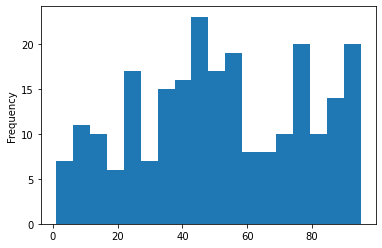

In [21]:
incidents_df['match_minute'] = incidents_df['match_minute'].apply(pd.to_numeric)
incidents_df['match_minute'].plot(kind='hist', bins = 18);

In [22]:
incidents_df[incidents_df['match_minute'] < 3]

,incident,team_decision,team,home_or_away,opposition,opposition_decision,date,year,month,match_minute,incident_penalty,incident_foul,incident_handball,incident_offside,incident_redcard,incident_yellowcard,players_involved,sum_incident_types
109,John McGinn goal disallowed for offside agains...,Against,Aston Villa,Away,Arsenal,For,Nov. 8,2020/2021,Nov,1.0,0,0,0,1,0,0,"[Barkley, John, Ross]",1.0
198,Penalty (scored by Pierre-Emerick Aubameyang) ...,For,Arsenal,Home,Watford,Against,July 26,2019/2020,Jul,2.0,1,1,0,0,0,0,"[Alexandre, Pierre-Emerick, Aubameyang, Dawson...",2.0


In [23]:
# To standardize stoppage time incidents (to match with that of first half 45'), all incidents past 90min mark 
# (i.e. stoppage time) will be assigned the timing 90min
for i, row in incidents_df.iterrows():
    if row['match_minute'] > 90:
        incidents_df.loc[i, 'match_minute'] = 90

In [24]:
# Export to Tableau for better visualization
export_date = dt.today().strftime('%Y%m%d')
incidents_df.to_csv(f'./data/EPL_VAR_Incidents_Processed_{export_date}.csv', index = False)

See `EPL VAR Analysis - Tableau Viz.twb` Tableau workbook for more information

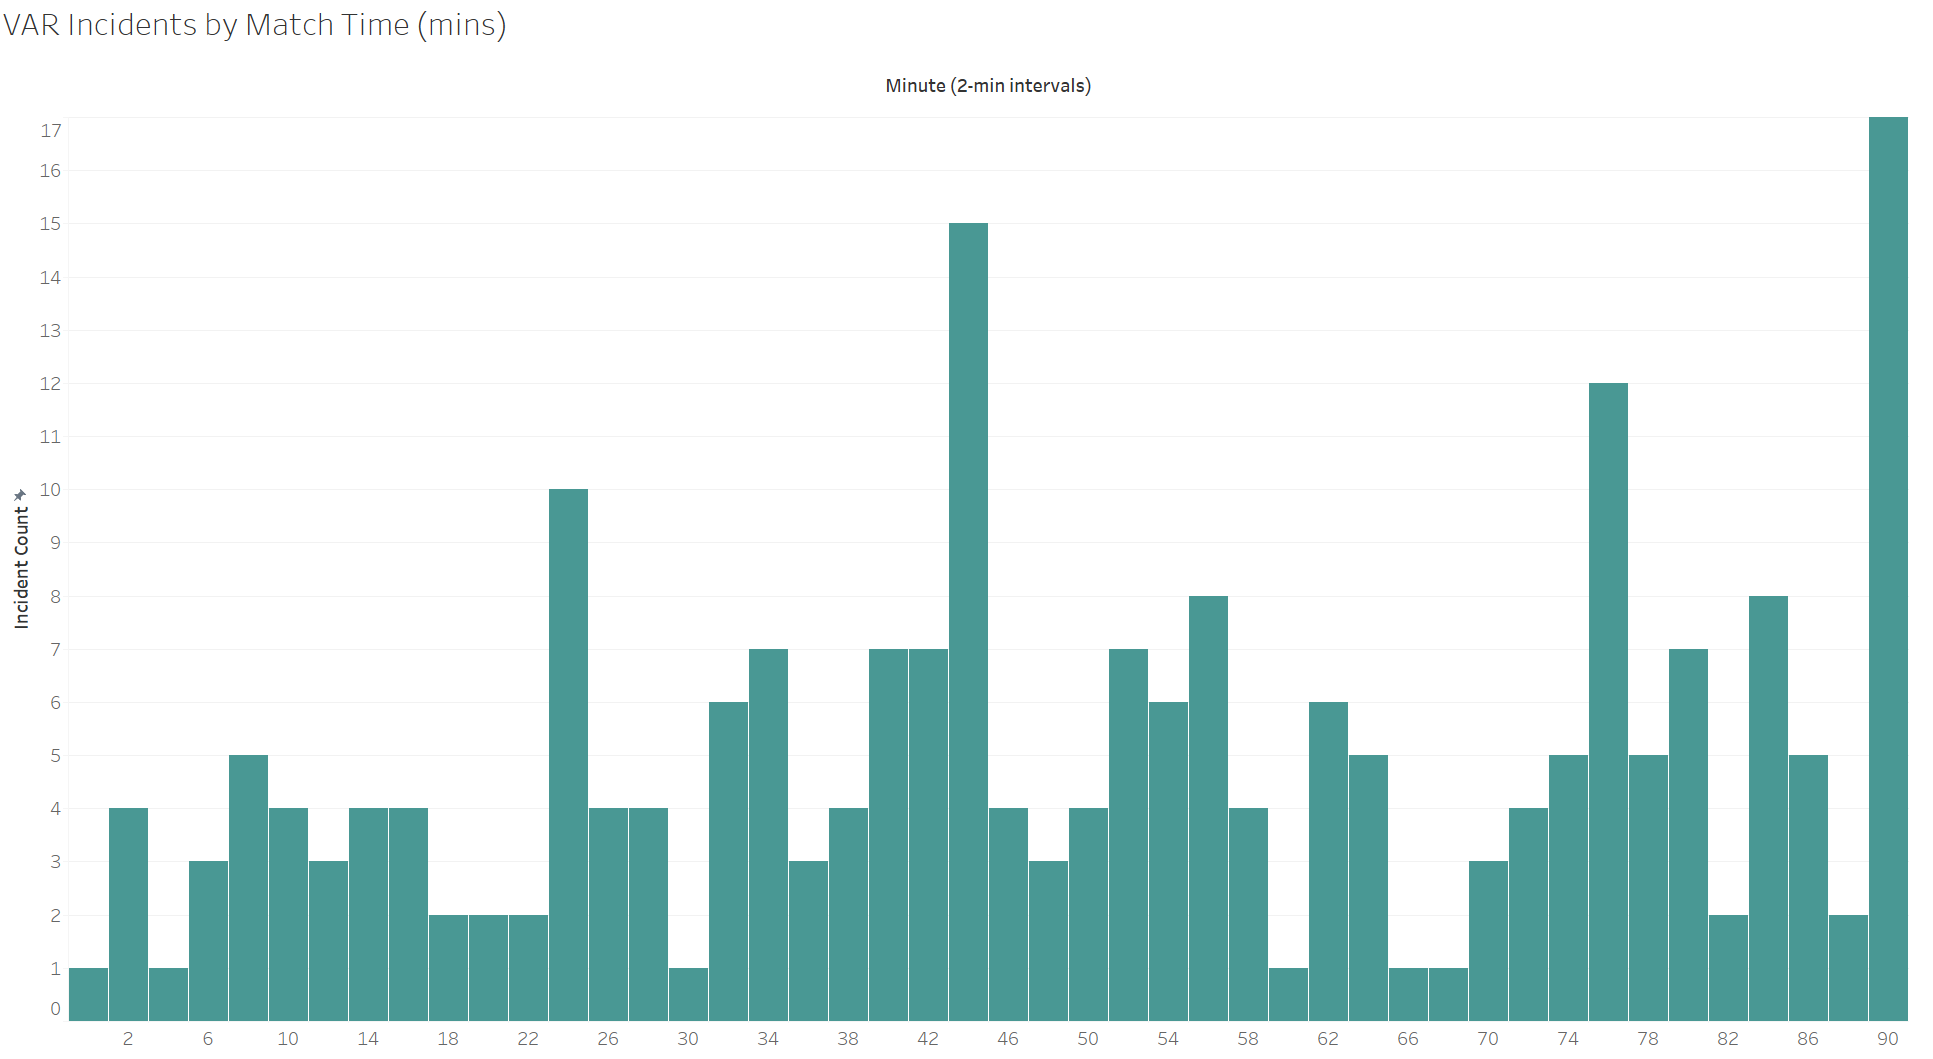

*Image from `EPL VAR Analysis - Tableau Viz` Tableau workbook*

- We can see some pattern of 'W' trend for each half i.e. Spikes in VAR incidents in the middle and towards the end of the half
- Incidents occurring at 45min and 90min mark include stoppage time incidents (Verified by manually checking a sample on https://www.premierleague.com/results). This essentially means that incidents happening from 46th min onwards belong to the second half

In [25]:
len(incidents_df[(incidents_df['match_minute'] >= 44) & (incidents_df['match_minute'] <=45)])

17